# Data preparation / Model

The purpose of this notebook is to prepare the image data aswell as define and train the model.

## Configuration

This unit imports necessary libraries and defines settings for the model. It also validates the dataset.

In [1]:
# Import libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.layers import Conv2D, Dropout, Flatten, Dense, BatchNormalization, MaxPooling2D
import cv2
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import dataset

2023-10-12 11:07:48.800797: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-12 11:07:49.116744: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-12 11:07:49.116791: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-12 11:07:49.116831: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-12 11:07:49.217095: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-12 11:07:49.218103: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
# Vars
BATCH_SIZE = 4
EPOCHS = 10
MODEL_NAME = 'model_final'
LOSS = 'binary_crossentropy'
METRICS = ['accuracy']

IMAGES_DIR = os.path.join(dataset.ROOT_DIR, 'assets', 'images')
save_figure = lambda filename: plt.savefig(os.path.join(IMAGES_DIR, filename))

In [3]:
# Initialize project dataset object
project_dataset = dataset.ProjectDataset()

In [4]:
# Make sure all images are jpg or png
invalid_images = 0

for file in project_dataset.image_filepaths()['all']['all']:
    if not file.endswith('.jpg') or file.endswith('.png'):
        invalid_images += 1
        
print(f'Invalid images: {invalid_images}')

Invalid images: 0


## Data preparation & Image augmentation

__This unit prepares the data using the following steps:__

    - Defines X and y variables from dataset
    - One-hot encodes the y variables
    - Creates tensorflow datasets
    - Performs image augmentation on the datasets
    - Shuffle and batches the datasets

In [5]:
# Load images and labels as np array
images = project_dataset.images_array(normalize=True, resize=True)
labels = project_dataset.labels()

# Define X and y vars
X_train = images['train']['all']
y_train = labels['train']['all']

X_test = images['test']['all']
y_test = labels['test']['all']

X_val = images['val']['all']
y_val = labels['val']['all']

In [6]:
# Flatten and reshape arrays for tensorflow data api
X_train = np.array([image.flatten() for image in X_train])
X_test = np.array([image.flatten() for image in X_test])
X_val = np.array([image.flatten() for image in X_val])

X_train = X_train.reshape(-1, 200, 200, 3)
X_test = X_test.reshape(-1, 200, 200, 3)
X_val = X_val.reshape(-1, 200, 200, 3)

In [7]:
# One hot encode labels
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y=y_train, num_classes=2)
y_test = to_categorical(y=y_test, num_classes=2)
y_val = to_categorical(y=y_val, num_classes=2)

In [8]:
# Create tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

2023-10-12 11:08:05.032818: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1728000000 exceeds 10% of free system memory.
2023-10-12 11:08:07.603435: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 576000000 exceeds 10% of free system memory.
2023-10-12 11:08:09.652550: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 576000000 exceeds 10% of free system memory.


In [9]:
# Perform image augmentation
def apply_augmentation(image, label):
    # Apply image augmentation operations
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)

    return image, label

# Apply to the dataset
train_dataset = train_dataset.map(apply_augmentation)

In [10]:
# Shuffle, prefetch and batch datasets
train_dataset = train_dataset.shuffle(buffer_size=1000)
test_dataset = train_dataset.shuffle(buffer_size=1000)
val_dataset = train_dataset.shuffle(buffer_size=1000)

train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

## Define model

This unit defines the model architecture and compiles the model using provided settings.

In [11]:
def create_model(hidden_layer_size, filters, dropout, learning_rate):
    # Pull in vars
    global BATCH_SIZE
    global LOSS
    global METRICS

    # Define model architecture
    model = Sequential()

    model.add(Conv2D(filters[0], (3, 3), 1, activation='relu', input_shape=(200, 200, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Dropout(dropout[0]))

    model.add(Conv2D(filters[1], (3, 3), 1, activation='relu'))
    model.add(BatchNormalization())

    model.add(Conv2D(filters[1], (3, 3), 1, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Dropout(dropout[0]))

    model.add(Conv2D(filters[2], (3, 3), 1, activation='relu'))
    model.add(BatchNormalization())

    model.add(Conv2D(filters[2], (3, 3), 1, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Dropout(dropout[1]))

    model.add(Flatten())
    model.add(Dense(hidden_layer_size, activation='relu'))

    model.add(Dense(2, activation='sigmoid'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer='adam', loss=LOSS, metrics=METRICS)
    
    return model

# Hyperparameter optimization

This unit aims to find the optimal hyperparameters for training the model using GridSearchCV

In [12]:
# Wrap model in KerasClassifier for compatibility with scikit-learn
# Specified values below are required default values, these will not be used during GridSearch
model = KerasClassifier(model=create_model, learning_rate=0.0, hidden_layer_size=0, filters=(0, 0, 0), dropout=(0, 0))

In [13]:
# Define parameters to explore
param_grid = {
    'hidden_layer_size': [256, 512],
    'learning_rate': [0.01, 0.001],
    'filters': [(8, 16, 32), (16, 32, 64)],
    'dropout': [(0.1, 0.3), (0.25, 0.5)]
}

In [14]:
# Define GridSearchCV object
search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=4,
)

In [15]:
# Fit to the training data
search.fit(X_train, y_train)

2023-10-12 11:08:22.937145: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 648000000 exceeds 10% of free system memory.


15/15 [==============================] - 1s 51ms/step


2023-10-12 11:08:50.109750: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 648000000 exceeds 10% of free system memory.


57/57 [==============================] - 29s 484ms/step - loss: 2.0605 - accuracy: 0.6956


GridSearchCV(cv=4,
             estimator=KerasClassifier(dropout=(0, 0), filters=(0, 0, 0), hidden_layer_size=0, learning_rate=0.0, model=<function create_model at 0x7ff97c040360>),
             param_grid={'dropout': [(0.1, 0.3), (0.25, 0.5)],
                         'filters': [(8, 16, 32), (16, 32, 64)],
                         'hidden_layer_size': [256, 512],
                         'learning_rate': [0.01, 0.001]})

In [16]:
# Store the best parameters
best_params = search.best_params_

## Train model

This unit trains the model on the dataset and saves it.

In [17]:
# Create new model using best params
model = create_model(dropout=best_params['dropout'], filters=best_params['filters'], hidden_layer_size=best_params['hidden_layer_size'], learning_rate=best_params['learning_rate'])
# Show summary of model
model.summary()

Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_325 (Conv2D)         (None, 198, 198, 16)      448       
                                                                 
 batch_normalization_325 (B  (None, 198, 198, 16)      64        
 atchNormalization)                                              
                                                                 
 max_pooling2d_195 (MaxPool  (None, 99, 99, 16)        0         
 ing2D)                                                          
                                                                 
 dropout_195 (Dropout)       (None, 99, 99, 16)        0         
                                                                 
 conv2d_326 (Conv2D)         (None, 97, 97, 32)        4640      
                                                                 
 batch_normalization_326 (B  (None, 97, 97, 32)      

In [18]:
# Train the model
hist = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch = len(X_train) // BATCH_SIZE, validation_data=val_dataset)

Epoch 1/10
450/450 [==============================] - 55s 97ms/step - loss: 1.4450 - accuracy: 0.7494 - val_loss: 1.2662 - val_accuracy: 0.6478
Epoch 2/10
450/450 [==============================] - 55s 121ms/step - loss: 0.2901 - accuracy: 0.8833 - val_loss: 0.2630 - val_accuracy: 0.8928
Epoch 3/10
450/450 [==============================] - 54s 120ms/step - loss: 0.2212 - accuracy: 0.9044 - val_loss: 0.2579 - val_accuracy: 0.8906
Epoch 4/10
450/450 [==============================] - 54s 117ms/step - loss: 0.2329 - accuracy: 0.9100 - val_loss: 0.1776 - val_accuracy: 0.9344
Epoch 5/10
450/450 [==============================] - 52s 115ms/step - loss: 0.1894 - accuracy: 0.9339 - val_loss: 0.1640 - val_accuracy: 0.9489
Epoch 6/10
450/450 [==============================] - 43s 93ms/step - loss: 0.1685 - accuracy: 0.9411 - val_loss: 0.1143 - val_accuracy: 0.9544
Epoch 7/10
450/450 [==============================] - 52s 115ms/step - loss: 0.1423 - accuracy: 0.9361 - val_loss: 0.1645 - val_accu

In [19]:
# Save the model
model.save(os.path.join(dataset.ROOT_DIR, f'{MODEL_NAME}.h5'))

/workspace/.pyenv_mirror/user/3.11.6/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


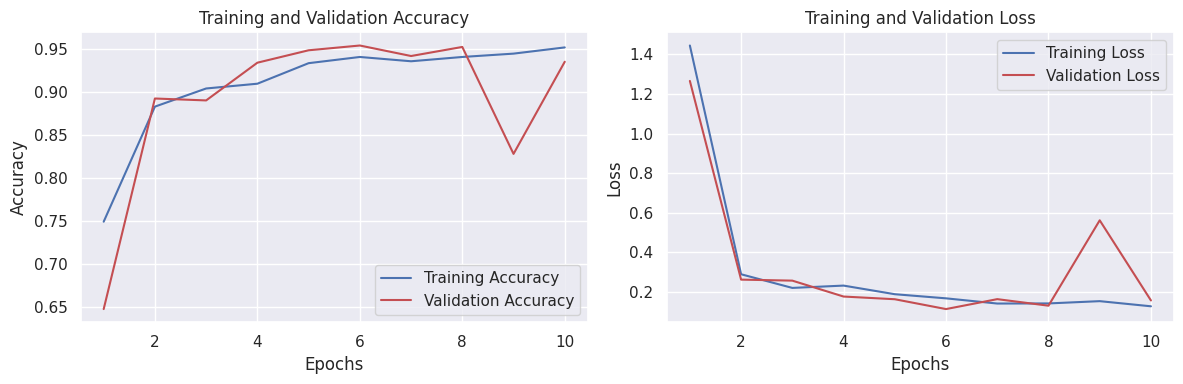

In [20]:
# Store metrics from history
training_accuracy = hist.history['accuracy']
training_loss = hist.history['loss']
validation_accuracy = hist.history['val_accuracy']
validation_loss = hist.history['val_loss']

# Calculate epochs
epochs = range(1, len(training_accuracy) + 1)

sns.set(style='darkgrid')
# Plot accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
save_figure('metrics_over_epochs.png')  # Save figure
plt.show()

## Evaluate model

This unit evaluates the model on the test dataset to provide metrics on data which the model has never seen.

In [21]:
# Evaluate on test data
loss, accuracy = model.evaluate(test_dataset)

450/450 [==============================] - 11s 20ms/step - loss: 0.1715 - accuracy: 0.9294


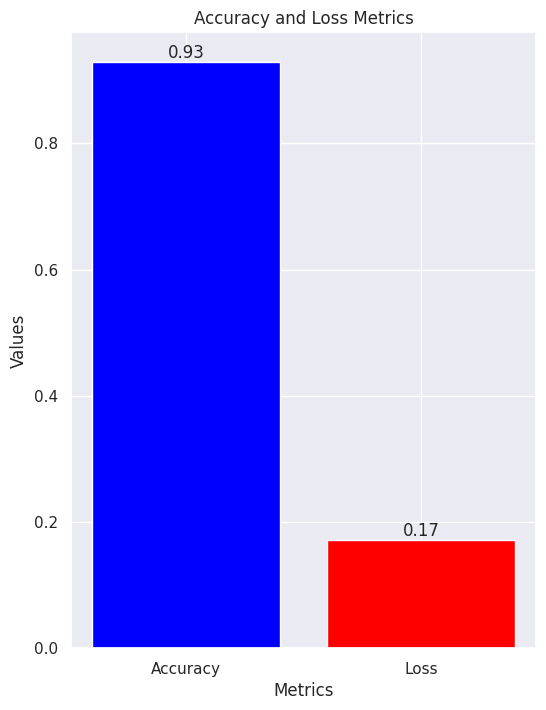

In [22]:
sns.set(style='darkgrid')

# Plot the evaluation metrics
plt.figure(figsize=(6, 8))

# Bar plot for accuracy and loss
metrics = ['Accuracy', 'Loss']
values = [accuracy, loss]

plt.bar(metrics, values, color=['blue', 'red'])
plt.xlabel('Metrics')
plt.ylabel('Values')

# Display the values on the bars
for i in range(len(metrics)):
    plt.text(i, values[i], f'{values[i]:.2f}', ha='center', va='bottom', fontsize=12)

plt.title('Accuracy and Loss Metrics')
save_figure('evaluation_metrics.png')  # Save figure
plt.show()


In [23]:
# Perform predictions and convert to [1, 0, 1, 0]
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

19/19 [==============================] - 2s 102ms/step


In [24]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[280  10]
 [ 53 257]]


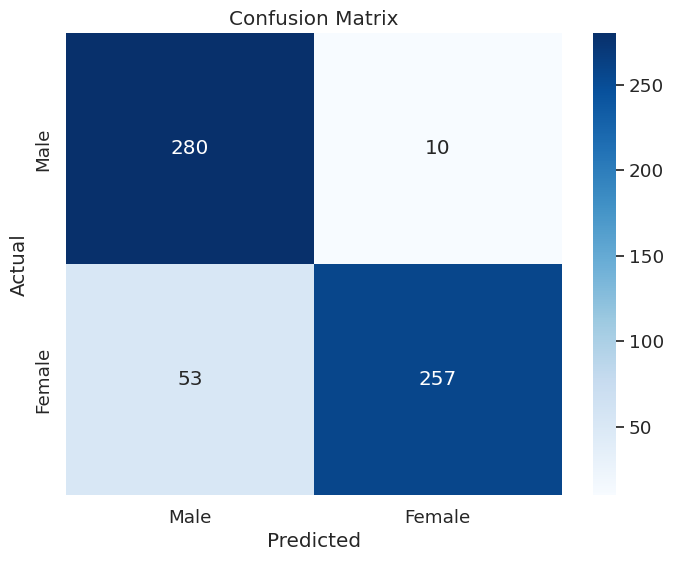

In [25]:
# Plot confusion matrix
class_labels = ['Male', 'Female']

plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

save_figure('confusion_matrix')  # Save figure
plt.show()

In [26]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)

Accuracy: 0.895
Precision: 0.9625468164794008
Recall: 0.8290322580645161
F1-Score: 0.8908145580589254


In [27]:
# Generate classification report
target_names = ['Male', 'Female']
report = classification_report(y_test, y_pred, target_names=target_names)

In [28]:
# Save report
with open('classification_report.txt', 'w') as file:
    file.write(report)